# 3. Different SVM Models

This live script is intended as supplementary material for section 3 of the report. For this live script, we will create a small dataset on which to test our Support Vector Machine models, and compare our four methods on this small dataset. In order to run this script, you will need to have installed:
 - MATLAB installed locally, as well as all packages needed to run the MATLAB kernel in jupyter (for installation reference, see [this website](https://walczak.org/2017/07/using-matlab-in-jupyter-notebooks-on-windows/)). 
 - Both the MOSEK optimisation package for MATLAB, as well as the YALMIP interface. 
For full details on formulations and meanings of variables and terms, please see Section 3 of the report.

Alternatively, the same content can be interactively viewed through the MATLAB live script also included. 

### Dataset
For easy visualisation, we will $m=16$ consider  data points, with only $n=2$ features. The first class of points (labelled as $+1$) will be lie within a square of size $2$ centred around the point $(2,2)$, whereas the second class of points (labelled as $-1$) will lie within a square of size $2$ centred at $(3,3)$. 

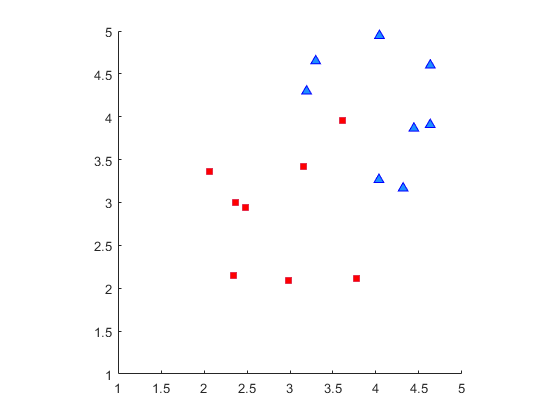

In [31]:
format short

m = 16;

x = [2*rand(m/2,2) + 2;
     2*rand(m/2,2) + 3];
y = [ones(m/2,1);
    -ones(m/2,1)];

scatter(x(1:m/2,1),x(1:m/2,2),40,'s','MarkerEdgeColor',rgb('Crimson'),'MarkerFaceColor',rgb('Red'))
hold on
scatter(x(m/2+1:end,1),x(m/2+1:end,2),40,'^','MarkerEdgeColor',rgb('Blue'),'MarkerFaceColor',rgb('DodgerBlue'))
xlim([1,5])
ylim([1,5])
axis square
hold off

As we can see, this data is not linearly separable, and so our soft-margin models are required. Below we implement some simple helper functions for visualising our solutions.

In [4]:
%%file visualise.m

function [] = visualise(m,x,y,w,gamma,sv)
    sz = 40;
    for i=1:m
        if y(i) == 1
            if isempty(sv(sv==i))
                scatter(x(i,1),x(i,2),sz,'s','MarkerEdgeColor',rgb('Crimson'),'MarkerFaceColor',rgb('Red'))
                hold on
            else
                scatter(x(i,1),x(i,2),sz,'s','MarkerEdgeColor',rgb('Green'),'MarkerFaceColor',rgb('LimeGreen'))
                hold on
            end
        else
            if isempty(sv(sv==i))
                scatter(x(i,1),x(i,2),sz,'^','MarkerEdgeColor',rgb('Blue'),'MarkerFaceColor',rgb('DodgerBlue'))
                hold on
            else
                scatter(x(i,1),x(i,2),sz,'^','MarkerEdgeColor',rgb('Green'),'MarkerFaceColor',rgb('LimeGreen'))
                hold on
            end
        end
    end
    fimplicit(@(X,Y) w(1)*X + w(2)*Y - gamma, 'r-')
    hold on
    fimplicit(@(X,Y) w(1)*X + w(2)*Y - gamma - 1, 'b--')
    hold on
    fimplicit(@(X,Y) w(1)*X + w(2)*Y - gamma + 1, 'b--')
    xlim([1,5])
    ylim([1,5])
    axis square
end

Created file 'C:\Users\Daniel\Desktop\Uni\Postgrad\1st Year\Term 2\COMP9417\Project\COMP9417-Project-Robust-SVMS-and-Breast-Cancer-Classification\S3 Different SVM Models\visualise.m'.


In [5]:
%%file visualise_robust.m

function [] = visualise_robust(m,x,y,w,gamma,sv,r)
    visualise(m,x,y,w,gamma,sv)
    %also includes uncertainty regions
    thetas = linspace(-pi,pi,50);
    for i=1:m
        circle_x = r(i)*cos(thetas)+x(i,1);
        circle_y = r(i)*sin(thetas)+x(i,2);
        plot(circle_x,circle_y,'k:','LineWidth',1)
        hold on
    end
    box off
    hold off
end

Created file 'C:\Users\Daniel\Desktop\Uni\Postgrad\1st Year\Term 2\COMP9417\Project\COMP9417-Project-Robust-SVMS-and-Breast-Cancer-Classification\S3 Different SVM Models\visualise_robust.m'.


## Model 1. Standard SVM

The standard SVM is formulated as a quadratic program in dual form:
$$ \min_{u\in\mathbb{R}^m}\quad \frac{1}{2} u^TYXX^TY^Tu - e^Tu \quad\mbox{subject to}\quad e^TY^Tu = 0,\quad 0\leq u\leq \lambda e$$

Below we create a function that takes as input, the data points $x$, their classification $y$ and the regularization parameter $\lambda$, then solves the above optimisation problem, and returns the weights $w$ and the bias $\gamma$, as well as an array $sv$ of indices that indicate the support vectors. 

In [6]:
%%file standard_svm.m

function [w,gamma,sv] = standard_svm(x,y,lambda)    
    %define parameters in desired form
    m = size(x,1); 
    Y = diag(y);
    X = x;
    e = ones(m,1);
    
    %define problem variables
    u = sdpvar(m,1);
    
    %objective function
    Obj = 0.5*u'*Y*(X*X')*Y'*u - e'*u;
    
    %constraints
    C = [e'*Y'*u == 0; u >= 0; u <= lambda*e];
    
    %solve
    optimize(C, Obj, sdpsettings('solver','mosek','verbose',0));
    
    %extract solution
    u = value(u);
    sv = [];
    for i =1:m
        if u(i) > 5*1e-8 && u(i) < lambda-5*(1e-8) %support vector, allowing for computer error
            sv = [sv i];
        end
    end
    if isempty(sv)
        error('No solution found. Please adjust tuning parameter. ')
    end
    w = X'*Y'*u;
    [~, I] = sort(u(sv),'ascend');
    new_sv = sv(I);
    ind = new_sv(ceil(end/2),2);
    gamma = -(1 - y(ind)*w'*x(ind,:)')/y(ind);
end

Created file 'C:\Users\Daniel\Desktop\Uni\Postgrad\1st Year\Term 2\COMP9417\Project\COMP9417-Project-Robust-SVMS-and-Breast-Cancer-Classification\S3 Different SVM Models\standard_svm.m'.


In [32]:
[w, gamma, sv] = standard_svm(x,y,0.5) 


w =

   -0.7316
   -0.8480


gamma =

   -5.3577


sv =

     6    14




We can visualise the solution as follows: the green points are support vectors; the red line is our classifier; the dotted blue lines are our margins. 

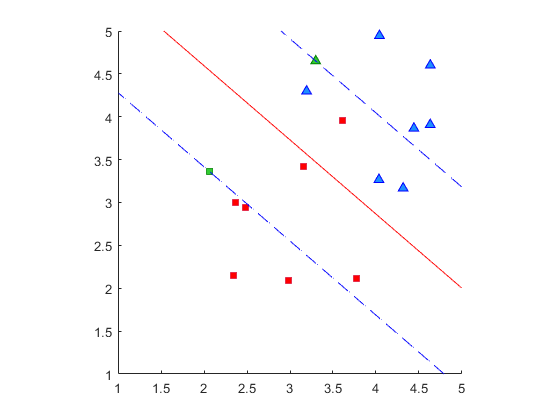

In [33]:
visualise(m,x,y,w,gamma,sv)

## Model 2: $L_1$-SVM

The $L_1$-SVM is formulated and solved via a $pq$ substitution, which turns it into a linear program:

$$ \min_{p,q,\gamma,\xi} e_n^T(p+q) + \lambda e_m^T\xi\quad\mbox{subject to}\quad Y(X(p-q)-e_m\gamma)+\xi\geq e_m,\quad p,q,\xi \geq 0 $$

In [13]:
%%file l1.m

function [w,gamma,sv] = l1_svm(x,y,lambda)
    %define parameters in desired form
    m = size(x,1); 
    n = size(x,2);
    Y = diag(y);
    X = x;
    em = ones(m,1);
    en = ones(n,1);
    
    %define problem variables
    p = sdpvar(n,1);
    q = sdpvar(n,1);
    gamma = sdpvar(1);
    xi = sdpvar(m,1);    
    
    %objective function
    Obj = en'*(p+q) + lambda*em'*xi;
    
    %constraints
    C = [Y*(X*(p-q)-em*gamma)+xi >= em; p >= 0; q >= 0; xi >= 0];
    
    %solve
    optimize(C, Obj, sdpsettings('solver','mosek','verbose',0));
    
    %extract solution
    p = value(p);
    q = value(q);
    w = value(p-q);
    gamma = value(gamma);
    sv = [];
    for i =1:m
        marg = abs(w'*x(i,:)'-gamma);
        if marg >= 1-5*(1e-8) && marg <= 1+5*(1e-8) %support vector, allowing for computer error
            sv = [sv i];
        end
    end
end

Created file 'C:\Users\Daniel\Desktop\Uni\Postgrad\1st Year\Term 2\COMP9417\Project\COMP9417-Project-Robust-SVMS-and-Breast-Cancer-Classification\S3 Different SVM Models\l1.m'.


In [34]:
[w, gamma, sv] = l1_svm(x,y,0.5)


w =

   -0.6631
   -0.9141


gamma =

   -5.4392


sv =

     5     6    14




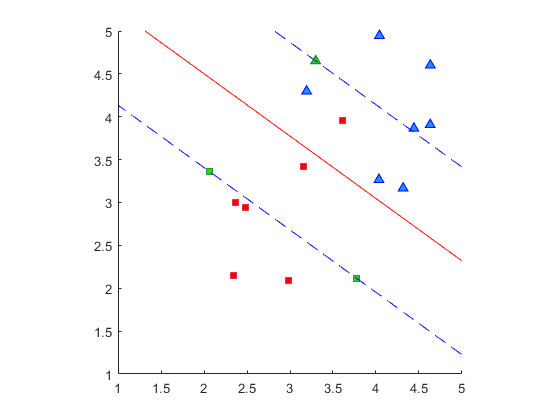

In [35]:
visualise(m,x,y,w,gamma,sv)

## Model 3. DrSVM

The Doubly Regularized SVM makes use of two regularization terms: one that is $L_1$ and one that is $L_2$:

$$ \min_{u} \frac{1}{2}u^T(\hat{Y}(\hat{X}(C+\nu I)^{-1}\hat{X}^T + \hat{e}\hat{e}^T)\hat{Y} + M)u - \hat{e}^Tu,\quad\mbox{subject to}\quad u\geq 0 $$

where each parameter is defined in section 3.3 of the report. 

In [54]:
%%file dr_svm.m

function [w,gamma,sv] = dr_svm(x,y,nu)
    %original parameters in desired form
    m = size(x,1); 
    n = size(x,2);
    Y = diag(y);
    X = x;
    e = ones(2*n+m,1);
    eh = [ones(m,1); zeros(2*n,1)];
    I = eye(2*n+m);
    
    %new problem-specific parameters
    Yhat = [Y zeros(m,2*n); zeros(2*n, m + 2*n)];
    Xhat = [zeros(m,m) X -X; zeros(2*n, m + 2*n)];
    C = [zeros(m, 2*n + m); zeros(2*n, m) eye(2*n)];
    V = inv(C+nu*I);
    Q = (Yhat*Xhat+I)*V*(Yhat*Xhat+I)' + Yhat*eh*eh'*Yhat';
    
    %optimisation problem and solution
    u = sdpvar(2*n+m,1);
    
    Obj = 0.5*u'*Q*u - eh'*u;    
    C = [u >= 0];
    
    optimize(C,Obj,sdpsettings('verbose',0,'solver','mosek'));
    
    u = value(u);
    
    sol = V*((Yhat*Xhat)'+I)*u;
    p = sol(m+1:m+n);
    q = sol(m+n+1:end);
    w = p - q;
    gamma = -eh'*Yhat*u;
    sv = [];
    for i =1:m
        marg = abs(w'*x(i,:)'-gamma);
        if marg >= 1-(1e-2) && marg <= 1+(1e-2) %support vector, allowing for computer error
            sv = [sv i];
        end
    end
end

Created file 'C:\Users\Daniel\Desktop\Uni\Postgrad\1st Year\Term 2\COMP9417\Project\COMP9417-Project-Robust-SVMS-and-Breast-Cancer-Classification\S3 Different SVM Models\dr_svm.m'.


In [59]:
[w,gamma,sv] = dr_svm(x,y,1024)


w =

   -0.6823
   -0.6074


gamma =

   -4.4767


sv =

     4




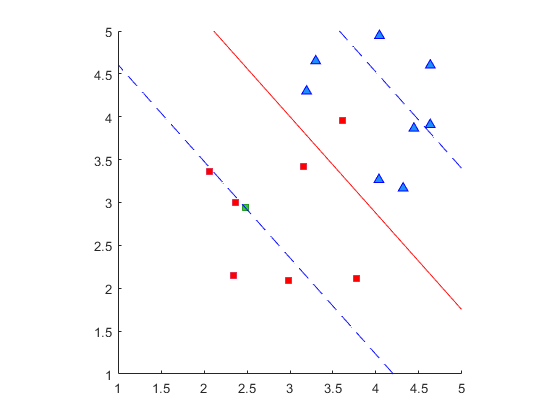

In [61]:
visualise(m,x,y,w,gamma,sv)

## Model 4: Robust SVM

To demonstrate the robust SVM, we will do the following:
  - For each datapoint $x_i, \ i=1,\dots,m$, we will choose a "radius of uncertainty" $r_i\in [0,0.2]$, to define for each datapoint an uncertainty set $U_i(r_i) = \bar{x}_i + r_i\mathbb{B}_2$. 
  - We solve the corresponding optimisation problem
  $$ \min_{w,\gamma,\xi,t_1,t_2} \frac{1}{2}t_1^2 + \lambda t_2 \quad\mbox{subject to}\quad y_i(\bar{x}_i^Tw - \gamma) - y_ir_i\Vert w \Vert_2 + \xi_i\geq 1, i=1,\dots,m,\quad \Vert w \Vert_2\leq t_1,\quad e^T\xi\leq t_2,\quad \xi \geq 0$$
  - We then plot the solution, and also include plots of the uncertainty regions for each datapoint.

In [90]:
%%file rob_svm.m

function [w, gamma, sv] = rob_svm(x,y,lambda,r)
    %problem parameters
    m = size(x,1); 
    n = size(x,2);
    e = ones(m,1);
    
    %variables
    w = sdpvar(n,1);
    gamma = sdpvar(1);
    xi = sdpvar(m,1);
    t = sdpvar(2,1);
    
    %objective
    Obj = 0.5*t(1)^2 + lambda*t(2);
    
    %constraints: socp
    C = [norm(w,2) <= t(1); e'*xi <= t(2); xi >= 0];
    for i = 1:m
        C = [C; y(i)*(x(i,:)*w-gamma) - y(i)*r(i)*t(1) + xi(i) >= 1];
    end
    
    %solve
    optimize(C,Obj,sdpsettings('verbose',0,'solver','mosek'));
    
    w = value(w);
    gamma = value(gamma);
    sv = [];
    for i =1:m
        marg = abs(w'*x(i,:)'-gamma);
        if marg >= 1-(1e-8) && marg <= 1+(1e-8) %support vector, allowing for computer error
            sv = [sv i];
        end
    end
end

Created file 'c:\Users\Daniel\Desktop\Uni\Postgrad\1st Year\Term 2\COMP9417\Project\COMP9417-Project-Robust-SVMS-and-Breast-Cancer-Classification\rob_svm.m'.


In [62]:
r = zeros(m,1);
for i=1:m
    r(i) = 0.2*rand(1);
end
[w, gamma, sv] = rob_svm(x,y,0.8,r)


w =

   -0.8380
   -1.0176


gamma =

   -6.3184


sv =

     []




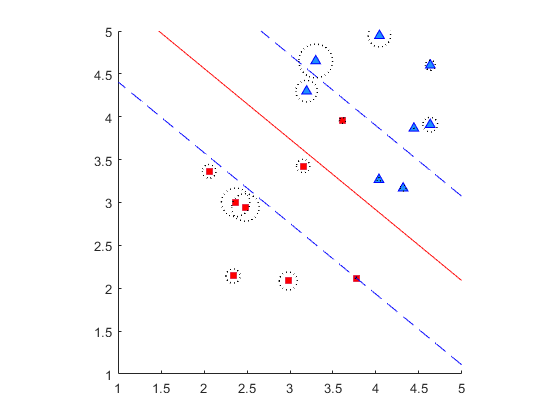

In [63]:
visualise_robust(m,x,y,w,gamma,sv,r)

It is worth noting that no support vectors are shown graphically for the robust method. The reason for this is because the robust approach does not use the raw data; instead it considers the worst case in each datapoint, in their uncertainty set; these are the points from which the support vectors are drawn. This process is inherent in the robust methodology.